In [ ]:
import pandas as pd
import math
import datetime
import statistics
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
from collections import OrderedDict
from matplotlib.dates import DateFormatter

In [ ]:
data = pd.read_excel("/content/rout (1).xlsx")

In [ ]:
depot_name = ['Colaba depot','Backbay depot','Mumbai Central depot','Worli depot', 'KalaKilla depot','Wadala depot','Dharavi depot','Dindoshi depot','Kurla depot','Bandra depot','Santacruz depot','Oshiwara depot','Poisar depot','Gorai depot','Malvani depot','Malad depot','Anik depot','Prateeksha Nagar depot','Deonar depot','Shivaji Nagar depot','Ghatkopar depot','Vikhroli depot', 'Magathane depot', 'Mulund depot' ]
# 'Majas depot' ,'Goregaon depot',  'Marol depot'
def hour_to_str(itime):
  tr =  str(math.trunc(itime)) + ':' + str(int(round((itime%1)*300/5)))
  itime = math.trunc(itime) + (itime%1)*3/5
  s=str(itime)
  clean_time = s.replace(".",":")

  if ( math.trunc(itime)<10) :
    clean_time = '0'+clean_time
    tr = '0' + tr
  clean_time  = clean_time[:5]
  if (len(clean_time)<5):
    clean_time+='0'

  return clean_time
charging_time_factor = 0.0
max_km=200
charge_full_time=6

def Factor_charging_time(charge_full_time):
  sum=0;
  for i in range(0,25):
      sum+=1/((2*(i/25)) +1.25);
  sum+=55/3.25;
  for i in range (80,100):
      sum+=1/(11.25 - (0.1*i));
  return charge_full_time/sum;

charging_time_factor = Factor_charging_time(charge_full_time)

In [ ]:
wait_queue_len = { depot: {} for depot in depot_name }
energy = {depot: {} for depot in depot_name}
for depot in depot_name:
  wait_queue_len[depot] = defaultdict(lambda: 0, wait_queue_len[depot])
  energy[depot] = defaultdict(lambda: 0, energy[depot])

In [ ]:
depotToBuses = {}
depotToBuses = defaultdict(lambda: [], depotToBuses)
total_buses = {}
total_buses = defaultdict(lambda: 0, total_buses)

In [ ]:
depot = 'Backbay depot'

In [ ]:

listOfNumBuses = []
print(depot)
for queue_len in range(1,100):

# total_buses = 0
  src = data[(data['Source Depot'] == depot)]
  dest = data[(data['Destination Depot'] == depot)]

  src.index = [i for i in range(len(src))]
  dest.index = [i for i in range(len(dest))]

  src_num = src['Bus Number'].count()
  dest_num = dest['Bus Number'].count()

  src_dict = {}
  src_dict = defaultdict(lambda: 0, src_dict)

  for i in range(0,src_num):
    temp2 = [x.strip() for x in src['Departure From Source'][i].split(',')]
    temp2.pop()
    for i in temp2:
      src_dict["{}".format(i)] += 1

  for i in range(0,dest_num):
    temp2 = [x.strip() for x in dest['Departure From Destination'][i].split(',')]
    temp2.pop()
    for i in temp2:
      src_dict["{}".format(i)] += 1

  src_dict_final = OrderedDict(sorted(src_dict.items()))



  bus_queue = []
  out_times = []
  merged_list = []

  def add_to_queue(arr_time, charge_time):
    if(len(bus_queue) < queue_len):
      bus_queue.append(arr_time + charge_time)
    else:
      queue_top = bus_queue[0]
      out_times.append(hour_to_str(queue_top))
      bus_queue.pop(0)
      bus_queue.append(max(arr_time, queue_top) + charge_time)
    bus_queue.sort()

  def precompute_and_queueing(s,distance,max_km,charge_full_time,time_taken):
    initial=s
    clean_time = s.replace(":",".")
    itime = float(clean_time);
    itime = math.trunc(itime) + (itime%1)*5/3
    itime += float(time_taken)/60

    charge_consumed = distance*100/max_km
    time_to_charge=(charge_consumed) * charging_time_factor/3.25

    # if queue_len == 6:
    #   if itime >= 26:
    #     print(s, distance, time_taken)

    # if itime >23:                                                             ##############################################
    #   itime -= 24                                                             ##############################################
    merged_list.append([itime, time_to_charge])

    # addToQueue(itime, time_to_charge)

  src_num = src['Bus Number'].count()
  dest_num = dest['Bus Number'].count()
  ready_dict = {}
  ready_dict = defaultdict(lambda: 0, ready_dict)
  src_dict = {}
  src_dict = defaultdict(lambda: 0, src_dict)

  # temp_dict = {}
  # temp_dict = defaultdict(lambda: 0, temp_dict)

  for i in range(0,src_num):
    temp2 = [x.strip() for x in src['Departure From Destination'][i].split(',')]
    dist = [x.strip() for x in src['Distance'][i].split(' ')]
    temp2.pop()
    dist.pop()
    distance = dist[0]

    time_taken = src['Journey Time'][i]
    if time_taken == "Not available":
      time_taken = int(round(float(distance)/18 * 60,0))


    # if queue_len == 6:
    #   print(src['Bus Number'][i],temp2)

    for j in temp2:
      precompute_and_queueing(j[:5],float(distance),max_km,charge_full_time,int(time_taken))

  for i in range(0,dest_num):
    temp2 = [x.strip() for x in dest['Departure From Source'][i].split(',')]
    dist = [x.strip() for x in dest['Distance'][i].split(' ')]
    temp2.pop()
    dist.pop()
    distance = dist[0]
    time_taken = dest['Journey Time'][i]
    if time_taken == "Not available":
      time_taken = int(round(float(distance)/18 * 60,0))
    for j in temp2:
      precompute_and_queueing(j[:5],float(distance),max_km,charge_full_time,int(time_taken))
  # print(merged_list)
  merged_list = sorted(merged_list, key=lambda x: x[0])  ##############################################

  ss = merged_list.copy()

  ss = sorted(ss, key=lambda x: x[0])
  art = []
  for x in ss:
    if x[0] not in art:
      art.append(x[0])
  final_merged_list = []
  for j in art:
    same_time_bus = []
    for x in ss:
      if x[0] == j:
        same_time_bus.append([x[0],x[1]])
    same_time_bus = sorted(same_time_bus, key =lambda y:y[1])
    for y in same_time_bus:
      final_merged_list.append(y)

  merged_list = final_merged_list.copy()
  ss = merged_list.copy()
  wait_queue = []
  # print(final_merged_list)

  while len(merged_list) != 0:
    arr_time= merged_list[0][0]
    charge_time = merged_list[0][1]
    if(len(bus_queue) < queue_len):
      # print("ji")
      del merged_list[0]
      bus_queue.append(arr_time + charge_time)
    else:
      bus_queue.sort()
      queue_top = bus_queue[0]
      # out_times.append(hour_to_str(queue_top))
      # bus_queue.pop(0)
      x = 0
      while len(merged_list) != 0:
        if(merged_list[0][0] >  queue_top):
          break
        if len(bus_queue)>1:
          if (merged_list[0][0] + merged_list[0][1])<bus_queue[-1]:
            last = bus_queue.pop()
            bus_queue.append(merged_list[0][0] + merged_list[0][1])
            bus_queue.sort()
            queue_top = bus_queue[0]
            merged_list[0][1] = last - merged_list[0][0]


        wait_queue.append(merged_list[0])
        x +=1

        del merged_list[0]

      bus_queue.sort()
      queue_top = bus_queue[0]
      out_times.append(hour_to_str(queue_top))
      bus_queue.pop(0)

      wait_queue_len[depot][queue_top] += x

      if len(wait_queue) != 0:
        wait_queue.sort(key = lambda x: x[1])                                  #####################################################

        bus_queue.append(queue_top  + wait_queue[0][1])
        del wait_queue[0]
        bus_queue.sort()


  wait_queue.sort(key = lambda x: x[1])                                       ##################################################


  for [itime, time_to_charge] in wait_queue:
    # out_times.append(hour_to_str(itime+time_to_charge))
    add_to_queue(itime, time_to_charge)

  for bus in bus_queue:
    out_times.append(hour_to_str(bus))



  for tme in out_times:
      c = 0
      for i in range(len(tme)):
        if tme[i] ==':':
          c = i
          break
      if c == 2:
        ready_dict["{}".format(tme)] += 1

  ready_dict_final = OrderedDict(sorted(ready_dict.items()))

  final_dict = {}
  final_dict = defaultdict(lambda: 0, final_dict)
  final_dict = ready_dict_final.copy()

  # print(final_dict)

  for key,value in src_dict_final.items():
    if key in final_dict.keys():
      final_dict[key] -= value
    else:
      final_dict[key] = -1*value
  final_dict_new = OrderedDict(sorted(final_dict.items()))

  sum=0
  for key, value in final_dict_new.items():
    sum += value
    final_dict_new[key]=sum
  min_val = 0
  for key, value in final_dict_new.items():
    min_val = min(min_val,value)


  end_val = final_dict_new[list(final_dict_new.keys())[-1]]
  kk = final_dict_new.keys()


  # plt.figure(figsize=(20, 15))
  # plt.plot( kk, final_dict_new.values())
  # print(final_dict_new)




  buses = (-1*min_val)
  # buses
  depotToBuses[depot].append(buses)

  listOfNumBuses.append(buses)
  total_buses[queue_len] += buses

# print(depot, end = ' - ')
# print(listOfNumBuses[0])

Backbay depot


In [ ]:
ap = []
def calt(a,b):
  return hour_to_str(a+b)

for x in ss:
  ap.append([calt(x[0],0), calt(0,x[1])])

print(ap)

[['06:26', '00:39'], ['06:46', '00:39'], ['06:54', '00:14'], ['06:56', '00:45'], ['07:06', '00:39'], ['07:07', '00:15'], ['07:10', '00:42'], ['07:11', '00:18'], ['07:11', '00:23'], ['07:14', '00:14'], ['07:17', '00:15'], ['07:18', '00:20'], ['07:21', '00:26'], ['07:22', '00:45'], ['07:23', '00:20'], ['07:28', '00:18'], ['07:30', '00:26'], ['07:31', '00:08'], ['07:31', '00:23'], ['07:31', '00:39'], ['07:34', '00:14'], ['07:35', '00:42'], ['07:35', '00:18'], ['07:39', '00:26'], ['07:43', '00:20'], ['07:43', '00:18'], ['07:46', '00:23'], ['07:47', '00:45'], ['07:47', '00:26'], ['07:49', '00:09'], ['07:52', '00:15'], ['07:52', '00:17'], ['07:52', '00:20'], ['07:54', '00:14'], ['07:56', '00:26'], ['07:56', '00:18'], ['07:56', '00:39'], ['07:58', '00:08'], ['07:59', '00:23'], ['08:00', '00:15'], ['08:00', '00:17'], ['08:00', '00:30'], ['08:00', '00:42'], ['08:01', '00:18'], ['08:01', '00:23'], ['08:02', '00:32'], ['08:02', '00:45'], ['08:03', '00:20'], ['08:04', '00:26'], ['08:05', '00:09'],

In [ ]:
print(src_dict_final)

OrderedDict([('05:30', 1), ('05:40', 1), ('05:47', 1), ('06:00', 5), ('06:03', 1), ('06:05', 2), ('06:09', 1), ('06:15', 2), ('06:17', 1), ('06:18', 1), ('06:20', 2), ('06:25', 1), ('06:27', 1), ('06:30', 4), ('06:34', 1), ('06:35', 3), ('06:36', 1), ('06:38', 1), ('06:43', 1), ('06:44', 1), ('06:45', 2), ('06:46', 1), ('06:50', 2), ('06:52', 2), ('06:55', 4), ('06:57', 1), ('07:00', 4), ('07:02', 1), ('07:04', 1), ('07:06', 1), ('07:07', 1), ('07:10', 3), ('07:12', 1), ('07:13', 1), ('07:15', 4), ('07:18', 1), ('07:20', 7), ('07:22', 1), ('07:25', 3), ('07:28', 1), ('07:29', 1), ('07:30', 1), ('07:32', 2), ('07:34', 3), ('07:35', 4), ('07:37', 2), ('07:38', 1), ('07:39', 1), ('07:40', 2), ('07:42', 3), ('07:44', 2), ('07:45', 3), ('07:47', 1), ('07:48', 1), ('07:49', 2), ('07:51', 1), ('07:52', 2), ('07:53', 1), ('07:54', 1), ('07:55', 3), ('07:56', 4), ('07:57', 2), ('07:59', 2), ('08:00', 2), ('08:01', 1), ('08:02', 1), ('08:03', 3), ('08:04', 1), ('08:05', 2), ('08:08', 4), ('08:09

In [ ]:
depotToBuses[depot] # chargers:[25, 26, 27, 28]

[1265,
 1118,
 1019,
 927,
 859,
 804,
 750,
 698,
 649,
 603,
 558,
 515,
 473,
 434,
 397,
 364,
 335,
 308,
 283,
 259,
 237,
 216,
 195,
 176,
 160,
 153,
 151,
 149,
 147,
 146,
 145,
 145,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144]

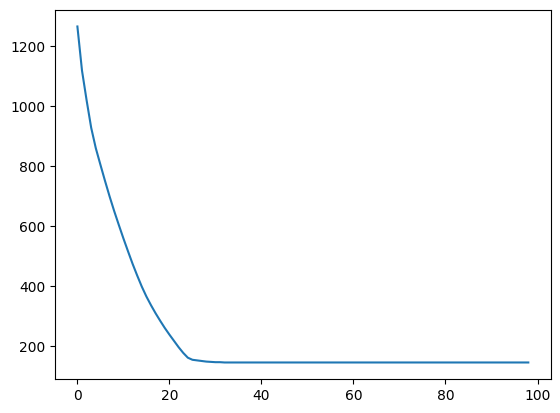

In [ ]:
plt.plot(listOfNumBuses)

In [ ]:
inc_red = [(listOfNumBuses[i]-listOfNumBuses[i+1]) for i in range(len(listOfNumBuses)-1)]

In [ ]:
print(inc_red)

[147, 99, 92, 68, 55, 54, 52, 49, 46, 45, 43, 42, 39, 37, 33, 29, 27, 25, 24, 22, 21, 21, 19, 16, 7, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


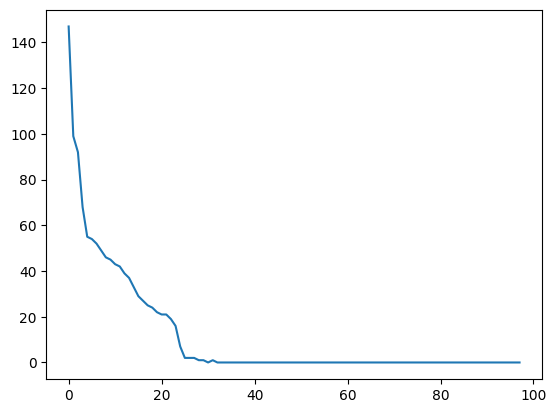

In [ ]:
plt.plot(inc_red)
#plt.plot(listOfNumBuses)
plt.show()